In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import qutip

import sys; sys.path.append("../../../Archive/Research/INQNET/superdense")
import squanch


from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD, Adam

K.set_floatx('float64')

from qpga import *

Using TensorFlow backend.


## Preparing NOON state with limited coupling strengths

In [2]:
N = 2
num_samples = 1000

in_data = np_to_k_complex(np.array([zero_state(N)] * num_samples))
out_data = np_to_k_complex(np.array([noon_state(N)] * num_samples))

In [3]:
model = QPGA(N, 10*N).as_sequential()
model.compile(optimizer=Adam(lr=0.01), 
              loss=antifidelity, 
              metrics=[antifidelity, 'mse'])

callback = FrameWriterCallback(input_state = in_data[0:1], target_state = out_data[0:1])

history = model.fit(in_data, out_data, epochs=3, batch_size=10, callbacks=[callback])

W0719 14:47:51.711277 4575856064 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 14:47:51.759806 4575856064 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0719 14:47:51.761366 4575856064 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 14:47:51.780894 4575856064 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 14:47:56.185518 4575856064 dep

Epoch 1/3
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0278 - antifidelity: 0.0278 - mean_squared_error: 0.0136
Epoch 2/3
1000/1000 [==============================] - 3s 3ms/step - loss: 5.7916e-07 - antifidelity: 5.7916e-07 - mean_squared_error: 0.0096
Epoch 3/3
1000/1000 [==============================] - 2s 2ms/step - loss: 2.0589e-11 - antifidelity: 2.0589e-11 - mean_squared_error: 0.0096


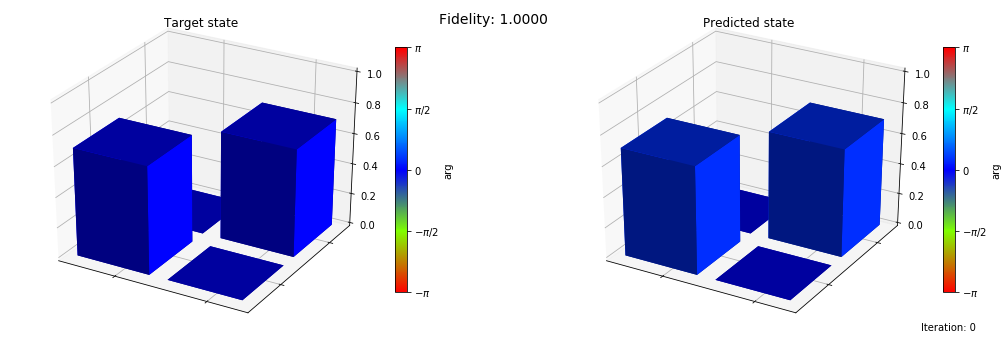

In [4]:
# plot_state_comparison(out_data[0:1], callback.predictions[-1], iteration=0, savefig=False)
plot_state_comparison(out_data[0:1], model.predict(in_data[0:1]), iteration=0)

## Implementing QFT

In [8]:
def QFT(qubits):
    '''Applies quantum Fourier transform to inputs'''
    N = len(qubits)
    for n in range(N, 0, -1):
        target = qubits[N - n]
        squanch.H(target)
        for m in range(1, n):
            squanch.CPHASE(qubits[N - n + m], target,2*np.pi/2**(m+1))

In [10]:
N = 4
states = np.array([get_random_state_vector(N) for _ in range(10000)])
states[0] = np.array([1]  + [0] * (2**N - 1), dtype=np.complex128)

qstream = squanch.QStream.from_array(np.copy(states), use_density_matrix=False)
for qsys in qstream:
    QFT(list(qsys.qubits))

out_states = np.copy(qstream.state)

in_data = np_to_k_complex(states)
out_data = np_to_k_complex(out_states)

In [16]:
learning_rate = 0.001 # 2**N * 0.001 
    
model = QPGA(N, 25*N).as_sequential()
model.compile(optimizer=Adam(lr=learning_rate), 
              loss=antifidelity, 
              metrics=[antifidelity, 'mse'])

callback = FrameWriterCallback(input_state = in_data[0:1], target_state = out_data[0:1])
history = model.fit(in_data, out_data, epochs=10, callbacks=[callback])

Epoch 1/10
10000/10000 [==============================] - 208s 21ms/step - loss: 0.1761 - antifidelity: 0.1761 - mean_squared_error: 0.0082
Epoch 2/10
10000/10000 [==============================] - 70s 7ms/step - loss: 2.5398e-05 - antifidelity: 2.5398e-05 - mean_squared_error: 5.9089e-04
Epoch 3/10
10000/10000 [==============================] - 70s 7ms/step - loss: 5.9583e-10 - antifidelity: 5.9583e-10 - mean_squared_error: 6.2580e-04
Epoch 4/10
10000/10000 [==============================] - 73s 7ms/step - loss: 1.4135e-13 - antifidelity: 1.4135e-13 - mean_squared_error: 6.2613e-04
Epoch 5/10
10000/10000 [==============================] - 71s 7ms/step - loss: 1.4187e-13 - antifidelity: 1.4187e-13 - mean_squared_error: 6.2613e-04
Epoch 6/10
10000/10000 [==============================] - 68s 7ms/step - loss: 1.4229e-13 - antifidelity: 1.4229e-13 - mean_squared_error: 6.2613e-04
Epoch 7/10
10000/10000 [==============================] - 69s 7ms/step - loss: 1.4257e-13 - antifidelity: 1.42

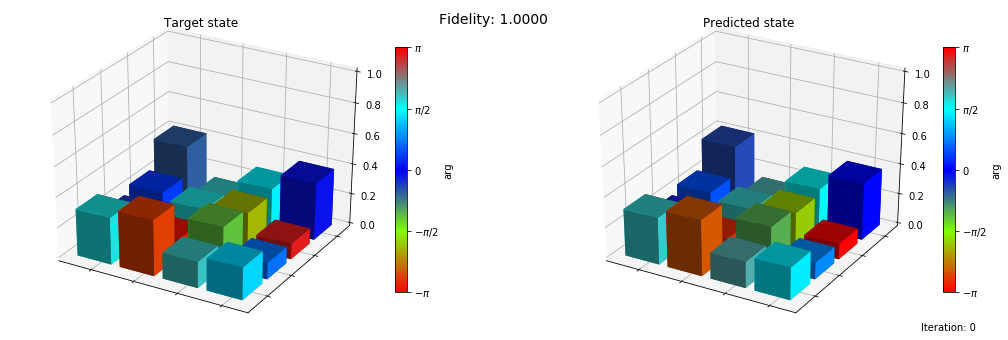

In [21]:
offset = 110
plot_state_comparison(out_data[offset+0:offset+1], model.predict(in_data[offset+0:offset+1]), iteration=0)

## NOON state preparation

In [10]:
N = 8
num_samples = 10000

in_state = np.array([1]  + [0] * (2**N - 1), dtype=np.complex128)
out_state = 1/np.sqrt(2) * np.array([1]  + [0] * (2**N - 2) + [1], dtype=np.complex128)

in_data = np_to_k_complex(np.array([in_state] * num_samples))
out_data = np_to_k_complex(np.array([out_state] * num_samples))

In [13]:
learning_rate = 0.01 # 2**N * 0.001
opt = Adam(lr=learning_rate)
    
model1 = build_model(N, 4*N)
model1.compile(optimizer=opt, loss='mse', metrics=['mse'])

callback = FrameWriterCallback()

history = model1.fit(in_data, out_data, epochs=3, batch_size=100, callbacks=[callback])

Epoch 1/3
10000/10000 [==============================] - 166s 17ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/3
10000/10000 [==============================] - 119s 12ms/step - loss: 4.5154e-04 - mean_squared_error: 4.5154e-04
Epoch 3/3
10000/10000 [==============================] - 123s 12ms/step - loss: 2.6562e-04 - mean_squared_error: 2.6562e-04


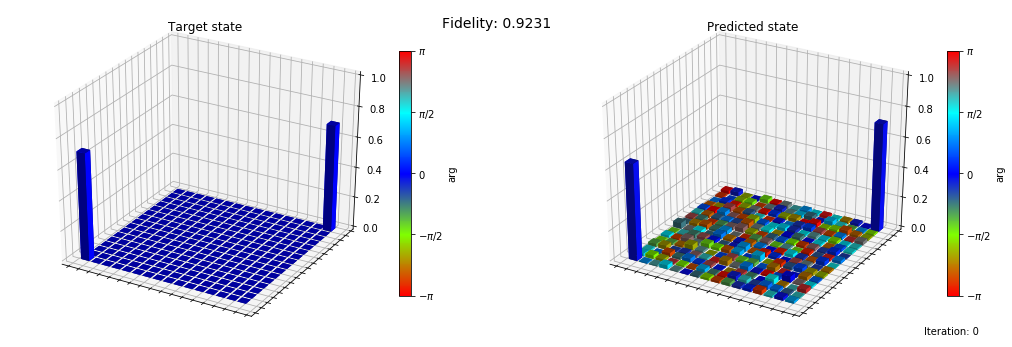

In [14]:
plot_state_comparison(out_data[0:1], model1.predict(in_data[0:1]), iteration=0)

In [15]:
for i, pred_state in enumerate(callback.predictions):
    print("Saving frame {}/{}...".format(i, len(callback.predictions)))
    plot_state_comparison(callback.predict_state, pred_state, iteration=i, savefig=True)

Saving frame 0/300...
Saving frame 1/300...
Saving frame 2/300...
Saving frame 3/300...
Saving frame 4/300...
Saving frame 5/300...
Saving frame 6/300...
Saving frame 7/300...
Saving frame 8/300...
Saving frame 9/300...
Saving frame 10/300...
Saving frame 11/300...
Saving frame 12/300...
Saving frame 13/300...
Saving frame 14/300...
Saving frame 15/300...
Saving frame 16/300...
Saving frame 17/300...
Saving frame 18/300...
Saving frame 19/300...
Saving frame 20/300...
Saving frame 21/300...
Saving frame 22/300...
Saving frame 23/300...
Saving frame 24/300...
Saving frame 25/300...
Saving frame 26/300...
Saving frame 27/300...
Saving frame 28/300...
Saving frame 29/300...
Saving frame 30/300...
Saving frame 31/300...
Saving frame 32/300...
Saving frame 33/300...
Saving frame 34/300...
Saving frame 35/300...
Saving frame 36/300...
Saving frame 37/300...
Saving frame 38/300...
Saving frame 39/300...
Saving frame 40/300...
Saving frame 41/300...
Saving frame 42/300...
Saving frame 43/300..